# Reading and Processing Surface Water Data

Upon completing the data processing for GRACE and GLDAS, we will next shift our focus to the acquisition and analysis of surface water data. Surface water data is gathered via reservoir storage monitoring performed at designated monitoring sites for each reservoir. Contrasting with GRACE and GLDAS, surface water data is typically fragmented and region-specific.

This notebook guides you through the process of downloading and analyzing surface water data specific to the Colorado River Basin. The methodologies demonstrated here could be applied to other regions within the United States, given the broad coverage of our data sources. However, for more detailed data, regional websites and databases may prove beneficial. As for regions outside the United States, this notebook should serve as a useful springboard for scraping, processing, and visualizing surface water data.

Surface water data for the Colorado River Basin is distributed across several platforms including:
- [the Bureau of Reclamation](https://www.usbr.gov/uc/water/hydrodata/nav.html)(Reclamation)
- [the United States Geological Survey](https://waterdata.usgs.gov/nwis/sw)(USGS)
-[the US Army Corps of Engineers](https://resreg.spl.usace.army.mil/cgi-bin/slLatestBasin.cgi?gila+elev)
- [the Salt River Project Watershed Connection](https://streamflow.watershedconnection.com/?location=Apache%20Lake%20(Horse%20Mesa%20Dam)&project=undefined)

In this Jupyter Notebook, however, we will restrict our focus to data from the Reclamation and the USGS for the reasons detailed below:

- Research papers that study the groundwater in the Colorado River Basin frequently use data from Lake Powell and Lake Mead to represent the totality of surface water in the basin. This data is readily provided by the Reclamation and USGS.
- The data from the US Army Corps of Engineers only spans the most recent 180 days and that from the Salt River Project extends up to a year. Given our interest in the timeframe from 2002 to 2023 (the most recent year), the data from these two sources is insufficient.

As we progress through this notebook, you will be guided through the steps to download data from the Reclamation and USGS, clean and process this data, and finally visualize the distribution of monitoring sites and storage for reservoirs within the basin.

In [81]:
# Loading necessary packages
import csv
import numpy as np
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import requests
from io import StringIO
from random import randint
from time import sleep
from requests.exceptions import RequestException
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

from fuzzywuzzy import fuzz
from datetime import date
from datetime import timedelta

import matplotlib.pyplot as plt

## Reading data from the Reclamation

The Reclamation hosted a [hydrologic database access portal](https://www.usbr.gov/uc/water/hydrodata/nav.html) for all relevent data on reservoirs they operated in the area of Colorado River Basin. The data we will be using are:
- a [metadata spreadsheet](https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv) that include all the information about monitoring sites (latitude, longitude, site_id, etc)
- reservoir storage data for each monitoring site measured in acre feet


In [82]:
def read_reclamation_from_url(url):
    '''
    Scrape content from the Bureau of Reclamation website
    '''
    # Define a session for HTTP requests
    session = requests.Session()

    # Define the retry settings: total=5 will attempt the request up to 5 times
    # status_forcelist=[500, 502, 503, 504] will retry if one of these status codes is returned
    retries = Retry(total=5, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])

    # Mount the retry settings to the session
    session.mount("https://", HTTPAdapter(max_retries=retries))

    try:
        # Send the request and catch any exceptions
        response = session.get(url, timeout=10)
        
        # If the response was successful, parse it as CSV
        if response.status_code == 200:
            # Add a lag between each retrival (1 to 5 seconds) to make the attempt seems artificial
            sleep(randint(1,5))
            data = response.content.decode('utf-8')
            return pd.read_csv(StringIO(data))
        # If the response was unsuccessful, print the status code for response
        else:
            print(f"Failed to download file from {url}, status code: {response.status_code}")
            return None
    # If the request to scrape was unsuccessful, print the error message
    except RequestException as e:
        print(f"Failed to download file: {e}")
        return None

In [83]:
# Load CRB shapefile
basin_shape = gpd.read_file('/home/yhuang21/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp')

# Load reservoir data from Bureau of Reclamation
reclamation_reservoir_metadata = read_reclamation_from_url('https://www.usbr.gov/uc/water/hydrodata/reservoir_data/meta.csv') 

In [84]:
# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(reclamation_reservoir_metadata['site_metadata.longi'], reclamation_reservoir_metadata['site_metadata.lat'])]
reservoirs_gdf = gpd.GeoDataFrame(reclamation_reservoir_metadata, geometry=geometry)

# Assign a Coordinate Reference System (CRS) to your GeoDataFrame. EPSG:4326 represents WGS 84 - Latitude/Longitude.
reservoirs_gdf.crs = "EPSG:4326"
basin_shape.crs = "EPSG:4326"

# Ensure that both GeoDataFrames have the same CRS before spatial join"
basin_shape = basin_shape.to_crs(reservoirs_gdf.crs)

# Perform spatial join so that only reservoirs inside the CRB shapefile will be selected
joined_gdf = gpd.sjoin(reservoirs_gdf, basin_shape, predicate='intersects')

# Filter by type_id (17 suggests the data is about reservoir storage) and select relevant columns
reclamation_reservoirs = joined_gdf[joined_gdf['datatype_id'] == 17][['site_metadata.lat', 'site_metadata.longi', 'site_metadata.site_name', 'site_id']]

In [85]:
# Remove duplicate rows
reclamation_reservoirs = reclamation_reservoirs.drop_duplicates().reset_index(drop=True)

# Rename Columns
reclamation_reservoirs = reclamation_reservoirs.rename(columns={'site_metadata.site_name':'name', 'site_metadata.lat':'lat', 'site_metadata.longi':'lon'})
reclamation_reservoirs['name'] = reclamation_reservoirs['name'].str.title()

In [86]:
# Show the first 5 rows of the dataframe
reclamation_reservoirs.head()

,lat,lon,name,site_id
0,40.365100,-105.236000,Flatiron Reservoir Nr Loveland,100081
1,40.320000,-105.210000,Carter Lake,100065
2,40.600000,-105.170000,Horsetooth Reservoir,100091
3,39.878317,-106.329748,Green Mountain Reservoir,100089
4,39.366647,-106.458926,Homestake Reservoir,100120


In [87]:
# Check if reservoirs have more than one monitoring sites.
# We will keep only one monitoring site for each reservoir if the data from the monitoring sites are similar
if reclamation_reservoirs['name'].nunique() != len(reclamation_reservoirs):
    
    # Create a dictionary that stores reservoirs with more than one monitoring well
    repeated_reservoir = {}

    # Record the reservoir name and the row number where the record exists for such reservoir into a key value pair in a dictionary
    def collect_indexes(group):
        if len(group) > 1:
            repeated_reservoir[group.name] = group.index.tolist()
    
    # Check if each reservoir name has more than one monitoring sites
    reclamation_reservoirs.groupby('name').apply(collect_indexes)
    
    print(repeated_reservoir)
else:
    print("All reservoirs have only one monitoring site for each.")

{'Dillon Reservoir': [10, 45], 'Granby Reservoir': [5, 46], 'Green Mountain Reservoir': [3, 47], 'Shadow Mountain Reservoir': [7, 49, 52], 'Williams Fork Reservoir': [8, 50]}


/tmp/ipykernel_641687/3364064054.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


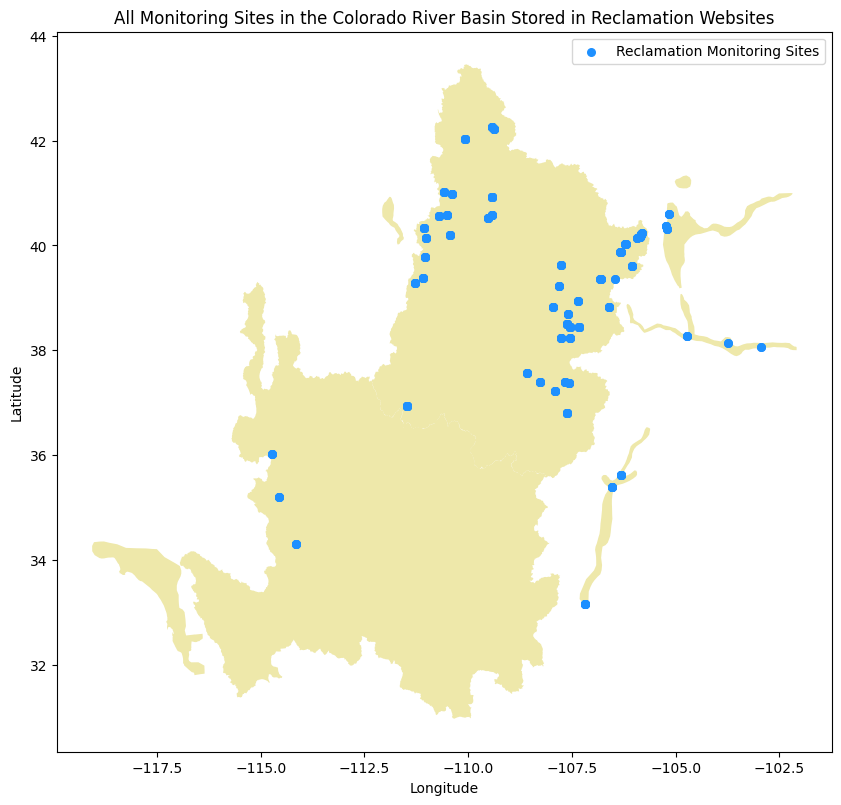

In [108]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod', label='Lower Basin')

# # Plot the reservoirs
joined_gdf.plot(ax=ax, marker='o', color='dodgerblue', markersize=30, label='Reclamation Monitoring Sites')

# # Add title and labels
plt.title('All Monitoring Sites in the Colorado River Basin Stored in Reclamation Websites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()


In [89]:
# URL link to each reservoir's storage data
reclamation_url_head = 'https://www.usbr.gov/uc/water/hydrodata/reservoir_data/'
reclamation_url_tail = '/csv/17.csv'

# Create an empty list to store all the temporary dataframes
data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in reclamation_reservoirs.itertuples(index=False):
    lat, lon, name, id = row
    # Scrape the website
    data = read_reclamation_from_url(reclamation_url_head + str(id) + reclamation_url_tail)

    # Calculate the monthly average storage for each site 
    data['datetime'] = pd.to_datetime(data['datetime'])
    data = data.set_index('datetime')
    data = data['storage'].resample('M').mean().reset_index()

    # Change the datetime input from YYYY-MM-DD to YYYY-MM
    data['datetime'] = data['datetime'].dt.to_period('M')

    # only selecting data from 2002 and onwards
    data = data[data['datetime'] >= '2002-01-01']

    # Add columns that documents the monitoring well's latitude, longitude, and name
    data['lat'] = lat
    data['lon'] = lon
    data['name'] = name

    #Store each dataframe of the monitoring sites into a list
    data_list.append(data)

In [90]:
# Merge the storage data stored in the list to a dataframe
reclamation_storage = pd.concat(data_list, ignore_index=True)

# For reservoirs with multiple monitoring stations, compute the average of the reservoir storage monitored by these stations for each month
reclamation_storage = reclamation_storage.groupby(['datetime', 'name']).agg({
    'lat': 'mean',
    'lon': 'mean',
    'storage': 'mean'
}).reset_index()

# Rename the columns
reclamation_storage.rename(columns={'lat': 'lat', 'lon': 'lon', 'storage': 'storage'}, inplace=True)

# Remove duplicate rows
reclamation_storage = reclamation_storage.drop_duplicates().reset_index(drop=True)

In [91]:
# For reservoirs with multiple monitoring stations, compute the average of the reservoir storage monitored by these stations for each month
reclamation_reservoirs = reclamation_reservoirs[['lat','lon','name']]
reclamation_reservoirs = reclamation_reservoirs.groupby(['name']).agg({
    'lat': 'mean',
    'lon': 'mean'
}).reset_index()

In [92]:
# A NaN in storage means no data is recorded for the reservoir at the given datetime
reclamation_storage

,datetime,name,lat,lon,storage
0,2002-01,Big Sandy Reservoir,42.249930,-109.428030,3269.594839
1,2002-01,Blue Mesa Reservoir,38.453050,-107.336770,538478.621613
2,2002-01,Carter Lake,40.320000,-105.210000,73129.161290
3,2002-01,Cochiti Lake,35.628230,-106.317160,49935.483871
4,2002-01,Crawford Reservoir,38.682940,-107.602850,NaN
...,...,...,...,...,...
14207,2023-07,Upper Stillwater Reservoir,40.565650,-110.700440,30317.356897
14208,2023-07,Vallecito Reservoir,37.378340,-107.574860,119059.609667
14209,2023-07,Vega Reservoir,39.221630,-107.799880,32336.167333
14210,2023-07,Williams Fork Reservoir,40.026902,-106.209554,96352.518519


## Reading data from the USGS

In [93]:
def read_usgs_from_url(url, is_metadata=False):
    response = requests.get(url)
    file_content = response.text

    if is_metadata:
        # Get the line number where data starts
        start_pos = file_content.find("site_no\tstation_nm\tsite_tp_cd\tdec_lat_va\tdec_long_va\tcoord_acy_cd\tdec_coord_datum_cd")
    else:
        start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

    # Extract data from start line till end
    data_content = file_content[start_pos:]

    try:
        # Create a pandas dataframe
        df = pd.read_csv(StringIO(data_content), delimiter='\t')
        df = df.drop(0)
    except pd.errors.EmptyDataError:
        # No data to parse from the file, return None
        return None

    if is_metadata:
        # Select only the columns of interest
        df = df[['dec_lat_va', 'dec_long_va','station_nm','site_no']]
        df['station_nm'] = df['station_nm'].str.title()
        df = df.rename(columns={'site_no':'site_id', 'station_nm':'name', 'dec_lat_va':'lat', 'dec_long_va':'lon'})
    else:
        # Extract columns of the format 'ddddd_00054_ddddd' (any length of d, d stands for digits)
        # These columns records the reservoir storage measured by the monitoring sites
        # The parameter code 00054 denotes reservoir storage 
        pattern = r'^\d+_00054_\d+$'  # regex pattern to match the desired column format
        matched_columns = df.filter(regex=pattern).columns

        # Reservoir storage could be stored as daily mean, exact measurement at 8:00 am, exact measurement at midnight, or instantaneous measurement
        # These are denoted by the chunk of digits following 00054
        # ddddd_00054_32400: Reservoir storage at midnight
        # ddddd_00054_00011: Instantaneous Reservoir storage
        # ddddd_00054_00003: Daily mean of Reservoir storage
        # ddddd_00054_30800: Reservoir storage at 8 am

        # Most of the monitoring sites only record one type of observation 
        # For monitoring sites with multiple types of observations, we select only one type of observation to record based on the following order.
        # In this case, observation type 00003 (daily mean) receive the highest order
        column_order = ['00003', '32400', '30800', '00011']

        # Select the first column that exists in the DataFrame according to your order
        for end_digits in column_order:
            column_name = next((col for col in matched_columns if col.endswith(end_digits)), None)
            if column_name:
                df = df[['datetime', column_name]]
                df = df.rename(columns={column_name: 'storage'})
                df.replace('NaN', np.nan, inplace=True)
                df['storage'] = pd.to_numeric(df['storage'], errors='coerce')
                break

    return df

In [94]:
# We select monitoring sites in USGS by filtering all the sites meeting our criteria using this website: https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_criteria=search_site_no&search_criteria=site_tp_cd&submitted_form=introduction
# Specifically, we selected monitoring sites with:
# - site id starting with 09 (denotes the monitoring site is in the Colorado River Basin, a list of site ids with the associated areas can be found on: https://help.waterdata.usgs.gov/faq/sites/do-station-numbers-have-any-particular-meaning)
# - has reservoir storage, acre-ft as the available parameter
# Then, we choose the output format option " Site-description information displayed in tab-separated format" and 
# select site identification number, site name, site type, Decimal latitude, Decimal longitude as the fileds to include in the site-description output
# These steps yield the url below

# Retrieve monitoring sites info from url
usgs_reservoirs = read_usgs_from_url('https://waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=09&search_site_no_match_type=beginning&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00054=1&group_key=county_cd&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&range_selection=days&period=365&date_format=YYYY-MM-DD&rdb_compression=file&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection', 
    is_metadata=True)

# Covert column types
usgs_reservoirs['lat'] = usgs_reservoirs['lat'].astype(float)
usgs_reservoirs['lon'] = usgs_reservoirs['lon'].astype(float)

# Define function to clean station name
def clean_station_name(name):
    for separator in [" Near ", " At "]:
        name = name.split(separator)[0]
    return name

# Apply function to clean column names 
# We want to clean the names because some of the USGS monitoring sites may overlap with the Reclamation monitoring sites
# We use the monitoring sites names as a comparison criteria to determine if the sites are the same
# Before cleaning, most of the USGS reservoir names look like "RIFLE GAP RESERVOIR NEAR RIFLE, CO"
# We are formating them as RIFLE GAP RESERVOIR
usgs_reservoirs['name'] = usgs_reservoirs['name'].apply(clean_station_name)

In [95]:
# Preview of the dataframe storing monitoring sites information from USGS
usgs_reservoirs.head()

,lat,lon,name,site_id
1,40.112763,-106.415032,"Wolford Mtn Reservoir Nr Kremmling, Co",09041395
2,39.626925,-107.757565,Rifle Gap Reservoir,09091900
3,39.224980,-107.811730,Vega Reservoir,09096100
4,38.817717,-106.605239,Taylor Park Reservoir,09108500
5,38.232769,-107.541726,Silver Jack Reservoir,09125800


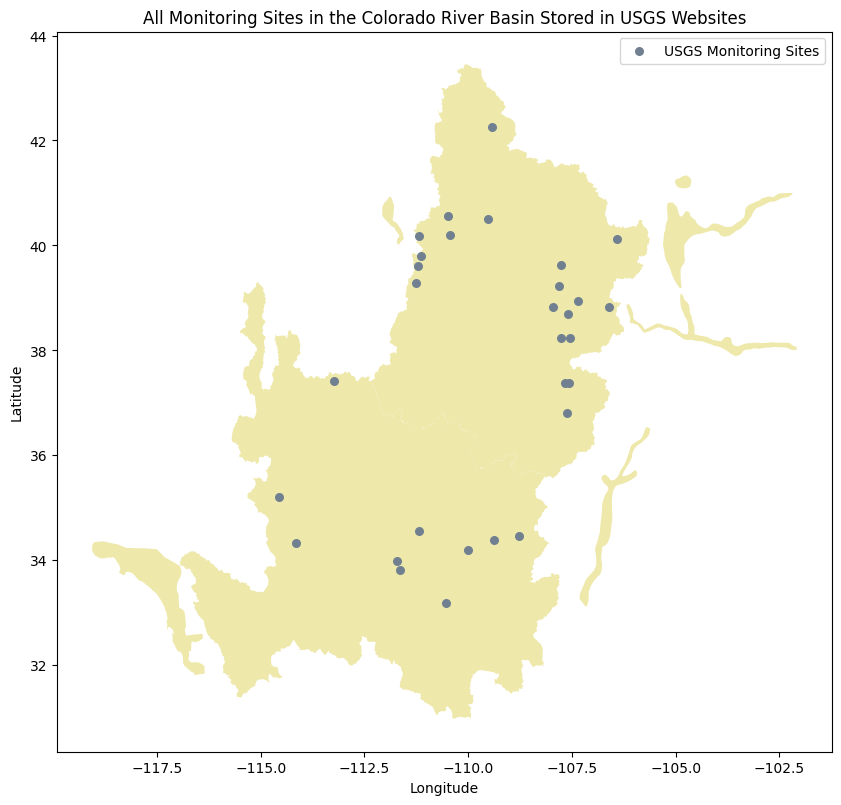

In [109]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod')

# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(usgs_reservoirs['lon'], usgs_reservoirs['lat'])]
usgs_reservoirs_gdf = gpd.GeoDataFrame(usgs_reservoirs, geometry=geometry)
usgs_reservoirs_gdf.crs = "EPSG:4326"

# # Plot the reservoirs
usgs_reservoirs_gdf.plot(ax=ax, marker='o', color='slategrey', markersize=30, label='USGS Monitoring Sites')

# # Add title and labels
plt.title('All Monitoring Sites in the Colorado River Basin Stored in USGS Websites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [97]:
# In this code chunk, we are dealing with repetitive monitoring wells stored in both the Reclamation dataset and the USGS dataset

# Iterate over each row in usgs_reservoirs
for i, row in usgs_reservoirs.iterrows():
    lat, lon, usgs_name = row['lat'], row['lon'], row['name'].lower()
    
    # Find rows in Reclamation reservoirs where the distance between its latitude and USGS reservoir's lat is  within the threshold (0.05) AND the distance between the longitudes are also within the threshold
    mask = ((reclamation_reservoirs['lat'] - lat).abs() < 0.05) & ((reclamation_reservoirs['lon'] - lon).abs() < 0.05)
    
    # For reclamation reservoirs that are too close to the USGS reservoir we are iterating, compare the names of the reclamation reservoir to the USGS reservoir
    for j, row_res in reclamation_reservoirs[mask].iterrows():
        print("---------")
        print('Name from USGS:', usgs_name)
        reclamation_name = row_res['name'].lower()
        print('Name from Reclamation:', reclamation_name)
        score = fuzz.ratio(usgs_name, reclamation_name)
        print('Similarity score', score)

        # We drop the USGS monitoring well If the reclamation reservoir name is too similar to the USGS reservoir name (similarity score > 90)
        if score > 90 or reclamation_name in usgs_name:
            usgs_reservoirs.at[i, 'name'] = row_res['name']
            break


---------
Name from USGS: rifle gap reservoir
Name from Reclamation: rifle gap reservoir
Similarity score 100
---------
Name from USGS: vega reservoir
Name from Reclamation: vega reservoir
Similarity score 100
---------
Name from USGS: taylor park reservoir
Name from Reclamation: taylor park reservoir
Similarity score 100
---------
Name from USGS: silver jack reservoir
Name from Reclamation: silver jack reservoir
Similarity score 100
---------
Name from USGS: crawford reservoir
Name from Reclamation: crawford reservoir
Similarity score 100
---------
Name from USGS: paonia reservoir
Name from Reclamation: paonia reservoir
Similarity score 100
---------
Name from USGS: fruit growers reservoir
Name from Reclamation: fruitgrowers reservoir
Similarity score 98
---------
Name from USGS: ridgway reservoir
Name from Reclamation: ridgway reservoir
Similarity score 100
---------
Name from USGS: big sandy reservoir
Name from Reclamation: big sandy reservoir
Similarity score 100
---------
Name fro

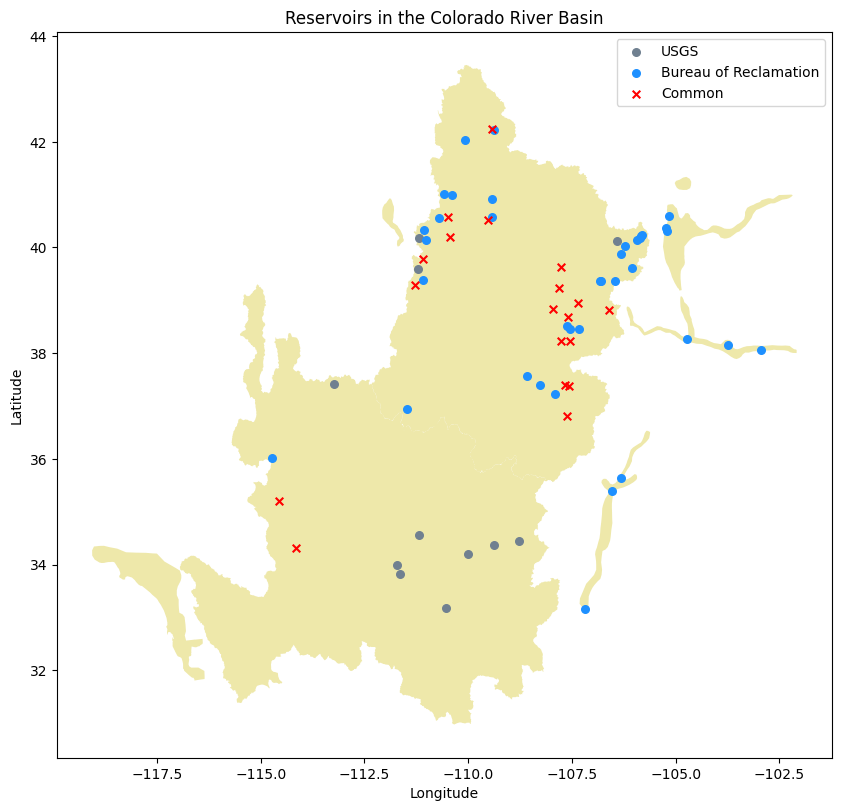

In [98]:
usgs_reservoirs['source'] = 'USGS'
reclamation_reservoirs['source'] = 'Bureau of Reclamation'
all_reservoirs_info = pd.concat([usgs_reservoirs, reclamation_reservoirs]).reset_index(drop=True)

# Create a dataframe that stores the wells that appear in both dataframes
common_reservoirs = all_reservoirs_info[all_reservoirs_info.duplicated('name', keep=False)]

# Update the 'source' column of the common wells in 'all_reservoirs_info'
unique_reservoirs = all_reservoirs_info.drop(common_reservoirs.index)

# Compute the averaged lat and lon for duplicated monitoring wells
common_reservoirs = common_reservoirs.groupby('name').agg({'lat':'mean', 'lon':'mean'}).reset_index()
common_reservoirs['source'] = 'Common'


# Convert your DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(unique_reservoirs['lon'], unique_reservoirs['lat'])]
unique_reservoirs_gdf = gpd.GeoDataFrame(unique_reservoirs, geometry=geometry)
unique_reservoirs_gdf.crs = "EPSG:4326"

geometry = [Point(xy) for xy in zip(common_reservoirs['lon'], common_reservoirs['lat'])]
common_wells_gdf = gpd.GeoDataFrame(common_reservoirs, geometry=geometry)
common_wells_gdf.crs = "EPSG:4326"

usgs_reservoirs_gdf = unique_reservoirs_gdf[unique_reservoirs_gdf['source'] == 'USGS']
reclamation_reservoirs_gdf = unique_reservoirs_gdf[unique_reservoirs_gdf['source'] == 'Bureau of Reclamation']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basins
basin_shape.plot(ax=ax, color='palegoldenrod')

# Plot the reservoirs
usgs_reservoirs_gdf.plot(ax=ax, marker='o', color='slategrey', markersize=30, label='USGS')
reclamation_reservoirs_gdf.plot(ax=ax, marker='o', color='dodgerblue', markersize=30, label='Bureau of Reclamation')
common_wells_gdf.plot(ax=ax, marker='x', color='red', markersize=30, label='Common')

# Add title, labels, and legend
plt.title('Reservoirs in the Colorado River Basin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
ax.legend()

# Show the plot
plt.show()

In [100]:
# URL link to each reservoir's storage data
usgs_url_head = 'https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no='
yesterday = date.today() - timedelta(days = 1)
usgs_url_tail = '&legacy=&referred_module=sw&period=&begin_date=2002-01-01&end_date=' + str(yesterday)

# Create an empty list to store all the temporary dataframes
data_list = []

# Iterate over each row in the reservoir dataframe to scrape the storage data at each monitoring site
for row in usgs_reservoirs.itertuples(index=False):
    lat, lon, name, id, _ = row
    data = read_usgs_from_url(usgs_url_head + str(id) + usgs_url_tail)
    if data is not None:
        data['datetime'] = pd.to_datetime(data['datetime'])
        data = data.set_index('datetime')

        # Calculate the monthly average storage for each site
        data = data['storage'].resample('M').mean().reset_index()
        data['datetime'] = data['datetime'].dt.to_period('M')
        data['lat'] = lat
        data['lon'] = lon
        data['name'] = name

        #Store each dataframe of the monitoring sites into a list
        data_list.append(data)

In [101]:
# suppose your list of dataframes is df_list
data_list.append(reclamation_storage)  # append the storage_df to the list
storage_df = pd.concat(data_list, ignore_index=True)

# For reservoirs with multiple monitoring stations, compute the average of the reservoir storage monitored by these stations for each month
storage_df =storage_df.groupby(['datetime', 'name']).agg({
    'lat': 'mean',
    'lon': 'mean',
    'storage': 'mean'
}).reset_index()

# Rename the columns
storage_df.rename(columns={'lat': 'lat', 'lon': 'lon', 'storage': 'storage'}, inplace=True)

In [103]:
storage_df

,datetime,name,lat,lon,storage
0,2002-01,Bartlett Reservoir,33.818097,-111.631805,66042.903226
1,2002-01,Big Sandy Reservoir,42.249524,-109.428663,3293.990968
2,2002-01,Blue Mesa Reservoir,38.453050,-107.336770,538478.621613
3,2002-01,Carter Lake,40.320000,-105.210000,73129.161290
4,2002-01,Cochiti Lake,35.628230,-106.317160,49935.483871
...,...,...,...,...,...
15849,2023-07,Vega Reservoir,39.223305,-107.805805,32375.417000
15850,2023-07,Williams Fork Reservoir,40.026902,-106.209554,96352.518519
15851,2023-07,Willow Creek Reservoir,40.146932,-105.942513,8756.636167
15852,2023-07,"Wolford Mtn Reservoir Nr Kremmling, Co",40.112763,-106.415032,65992.666667


In [104]:
# Define the bin size
bin_size = 0.25

# Bin the latitude and longitude data and calculate the midpoint
storage_df['lat'] = (np.floor(storage_df['lat'] / bin_size) * bin_size) + bin_size / 2
storage_df['lon'] = (np.floor(storage_df['lon'] / bin_size) * bin_size) + bin_size / 2

# convert unit from acre-feet to cubic kilometer
storage_df['storage'] = storage_df['storage'] * 0.000001233

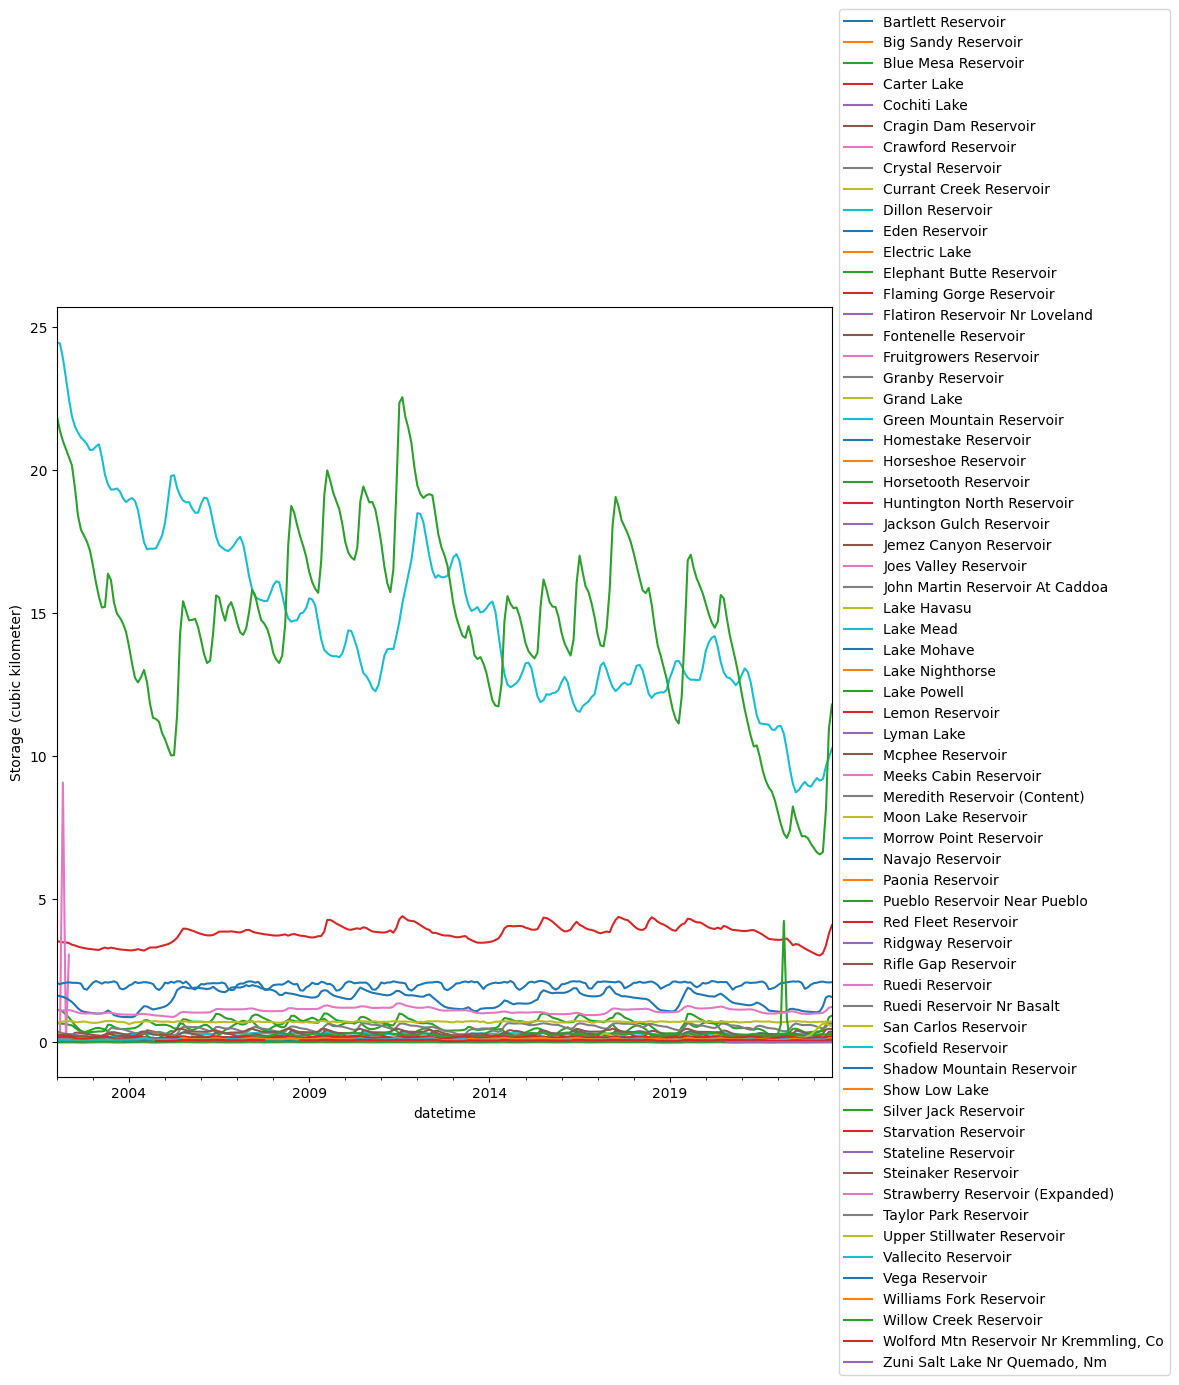

In [105]:
# Create a new figure
plt.figure(figsize=(10, 10))

# Iterate over the reservoir groups and plot each one
for name, group in storage_df.groupby('name'):
    group.plot(x='datetime', y='storage', label=name, ax=plt.gca())

# Display the legend and show the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Storage (cubic kilometer)')
plt.show()

In [ ]:
storage_df.to_csv('reservoir_storage.csv', index=False)